# Comprehensive Non-Relapse Mortality (NRM) Data Analysis

This notebook provides a comprehensive exploratory data analysis of the NRM dataset for AML/MDS transplant patients.

## Dataset Overview
- **File**: ML for AML MDS - for FG - NRM.xlsx
- **Focus**: Non-relapse mortality outcomes in transplant patients
- **Time Period**: 2016-2023

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Load and prepare the data
df = pd.read_excel('ML for AML MDS - for FG - NRM.xlsx')

# Add derived features
df['Transplant_Year'] = pd.to_datetime(df['Transplant Day Zero']).dt.year
df['Transplant_Month'] = pd.to_datetime(df['Transplant Day Zero']).dt.month
df['Sex_Label'] = df['Sex'].map({1: 'Male', 2: 'Female'})
df['NRM_Status'] = df['NRM'].map({0: 'No NRM', 1: 'NRM Event', 2: 'Censored/Alive'})
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 40, 50, 60, 100], labels=['≤40', '41-50', '51-60', '>60'])

print(f"Dataset loaded: {df.shape[0]} patients, {df.shape[1]} variables")
print(f"Date range: {df['Transplant_Year'].min()} - {df['Transplant_Year'].max()}")
df.head()

Dataset loaded: 258 patients, 13 variables
Date range: 2016 - 2023


,Study ID,Initials,Sex,DOB,Age,Transplant Day Zero,NRM,NRM_Days,Transplant_Year,Transplant_Month,Sex_Label,NRM_Status,Age_Group
0,NaN,SL,1,1961-09-03,61,2023-07-06,2,390,2023,7,Male,Censored/Alive,>60
1,NaN,RJ,1,1970-01-04,53,2023-06-30,2,405,2023,6,Male,Censored/Alive,51-60
2,NaN,VTN,1,1959-09-21,63,2023-06-27,0,204,2023,6,Male,No NRM,>60
3,NaN,JC,1,1969-10-11,53,2023-06-20,1,149,2023,6,Male,NRM Event,51-60
4,NaN,JW,1,1971-05-24,52,2023-06-02,1,59,2023,6,Male,NRM Event,51-60


## 1. Patient Demographics Overview

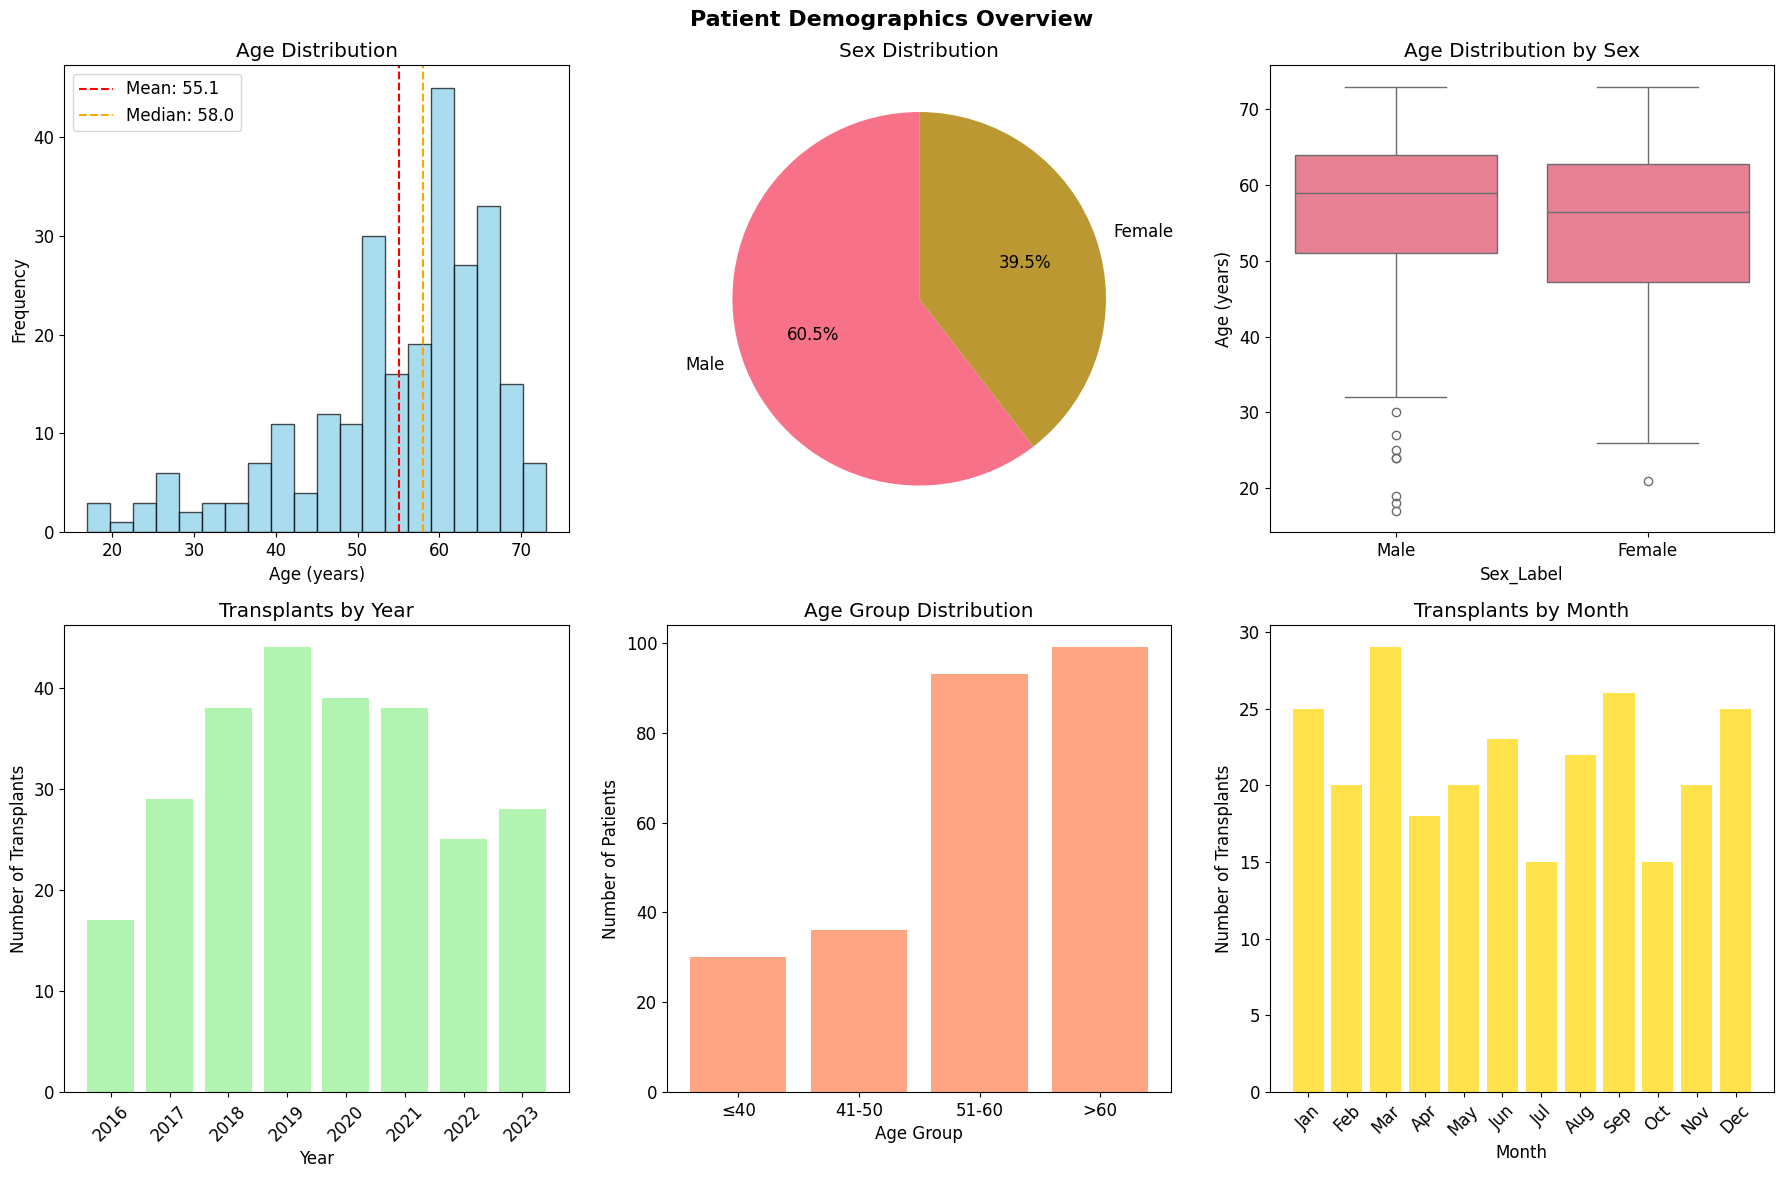

In [3]:
# Create comprehensive demographics dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Patient Demographics Overview', fontsize=16, fontweight='bold')

# 1. Age distribution
axes[0,0].hist(df['Age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(df['Age'].mean(), color='red', linestyle='--', label=f'Mean: {df["Age"].mean():.1f}')
axes[0,0].axvline(df['Age'].median(), color='orange', linestyle='--', label=f'Median: {df["Age"].median():.1f}')
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age (years)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# 2. Sex distribution
sex_counts = df['Sex_Label'].value_counts()
axes[0,1].pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Sex Distribution')

# 3. Age by sex
sns.boxplot(data=df, x='Sex_Label', y='Age', ax=axes[0,2])
axes[0,2].set_title('Age Distribution by Sex')
axes[0,2].set_ylabel('Age (years)')

# 4. Transplants by year
yearly_counts = df['Transplant_Year'].value_counts().sort_index()
axes[1,0].bar(yearly_counts.index, yearly_counts.values, alpha=0.7, color='lightgreen')
axes[1,0].set_title('Transplants by Year')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Number of Transplants')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Age groups
age_group_counts = df['Age_Group'].value_counts().sort_index()
axes[1,1].bar(age_group_counts.index, age_group_counts.values, alpha=0.7, color='coral')
axes[1,1].set_title('Age Group Distribution')
axes[1,1].set_xlabel('Age Group')
axes[1,1].set_ylabel('Number of Patients')

# 6. Monthly transplant pattern
monthly_counts = df['Transplant_Month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1,2].bar(range(1, 13), [monthly_counts.get(i, 0) for i in range(1, 13)], alpha=0.7, color='gold')
axes[1,2].set_title('Transplants by Month')
axes[1,2].set_xlabel('Month')
axes[1,2].set_ylabel('Number of Transplants')
axes[1,2].set_xticks(range(1, 13))
axes[1,2].set_xticklabels(month_names, rotation=45)

plt.tight_layout()
plt.show()

## 2. Non-Relapse Mortality (NRM) Analysis

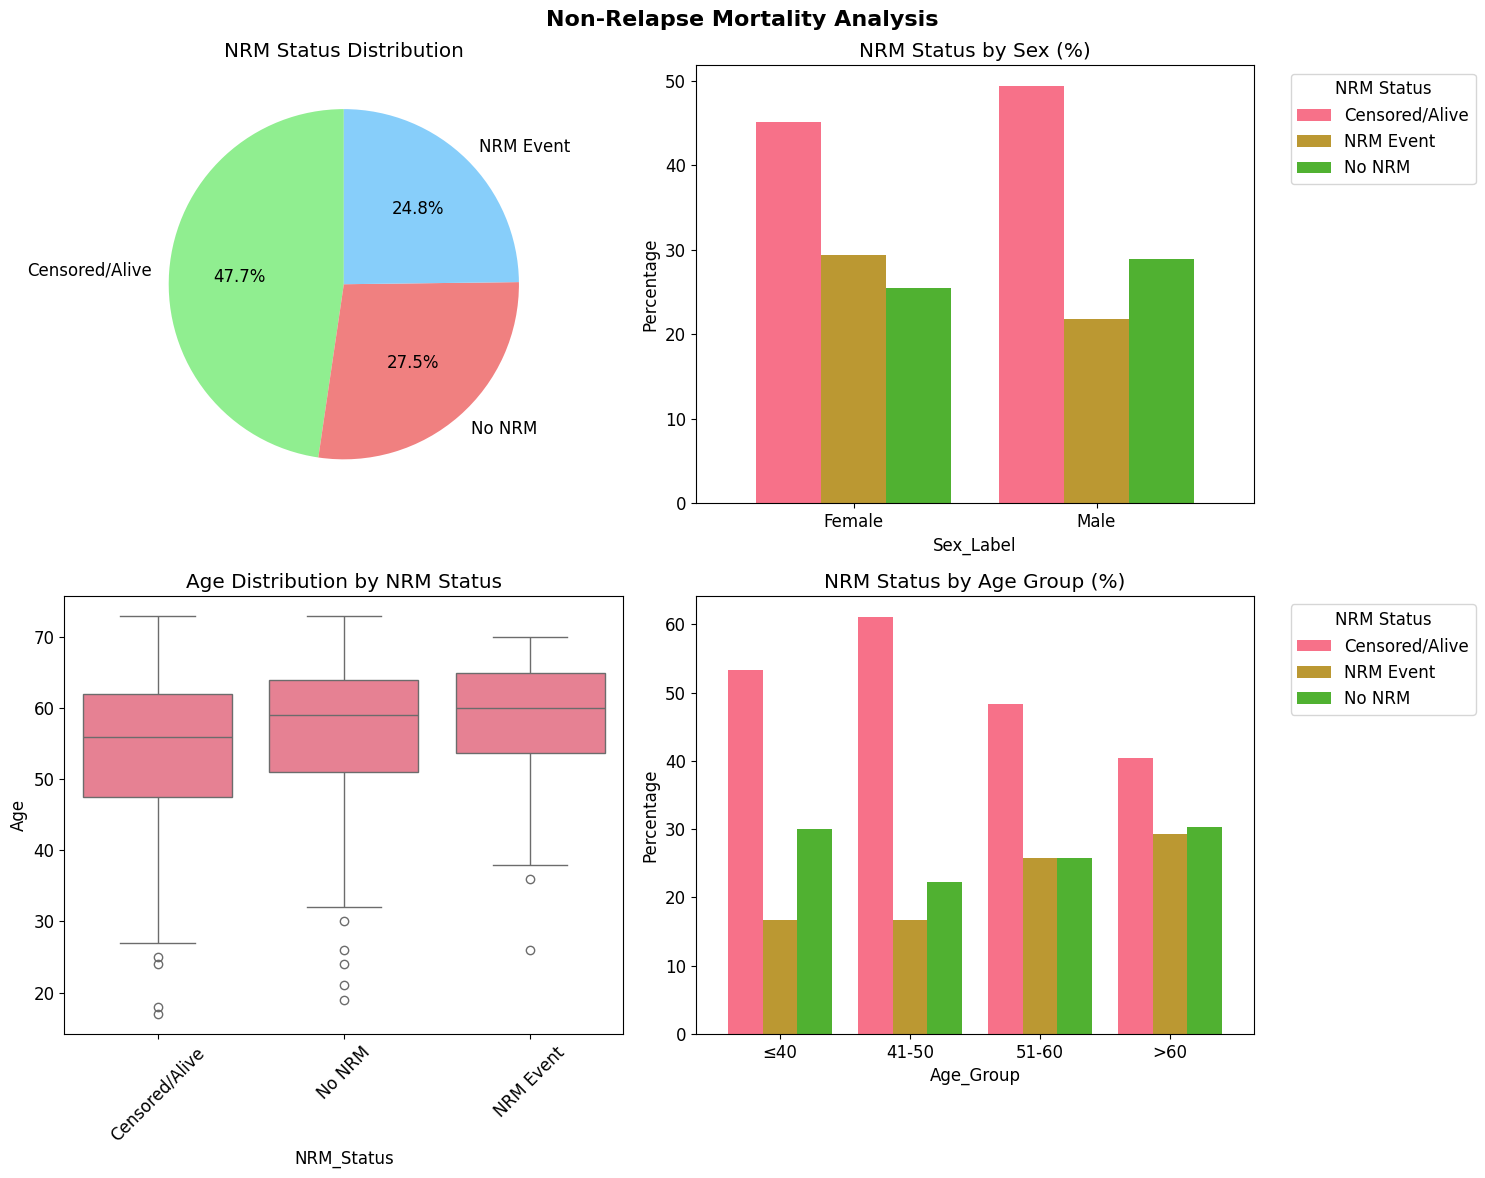


=== NRM Summary Statistics ===
Total patients: 258
NRM events: 64 (24.8%)
No NRM: 71 (27.5%)
Censored/Alive: 123 (47.7%)


In [4]:
# NRM status overview
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Non-Relapse Mortality Analysis', fontsize=16, fontweight='bold')

# 1. NRM status distribution
nrm_counts = df['NRM_Status'].value_counts()
colors = ['lightgreen', 'lightcoral', 'lightskyblue']
axes[0,0].pie(nrm_counts.values, labels=nrm_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
axes[0,0].set_title('NRM Status Distribution')

# 2. NRM by sex
nrm_sex_ct = pd.crosstab(df['Sex_Label'], df['NRM_Status'], normalize='index') * 100
nrm_sex_ct.plot(kind='bar', ax=axes[0,1], rot=0, width=0.8)
axes[0,1].set_title('NRM Status by Sex (%)')
axes[0,1].set_ylabel('Percentage')
axes[0,1].legend(title='NRM Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Age distribution by NRM status
sns.boxplot(data=df, x='NRM_Status', y='Age', ax=axes[1,0])
axes[1,0].set_title('Age Distribution by NRM Status')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. NRM by age group
nrm_age_ct = pd.crosstab(df['Age_Group'], df['NRM_Status'], normalize='index') * 100
nrm_age_ct.plot(kind='bar', ax=axes[1,1], rot=0, width=0.8)
axes[1,1].set_title('NRM Status by Age Group (%)')
axes[1,1].set_ylabel('Percentage')
axes[1,1].legend(title='NRM Status', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== NRM Summary Statistics ===")
print(f"Total patients: {len(df)}")
print(f"NRM events: {len(df[df['NRM'] == 1])} ({len(df[df['NRM'] == 1])/len(df)*100:.1f}%)")
print(f"No NRM: {len(df[df['NRM'] == 0])} ({len(df[df['NRM'] == 0])/len(df)*100:.1f}%)")
print(f"Censored/Alive: {len(df[df['NRM'] == 2])} ({len(df[df['NRM'] == 2])/len(df)*100:.1f}%)")

## 3. Temporal Analysis and Survival Patterns

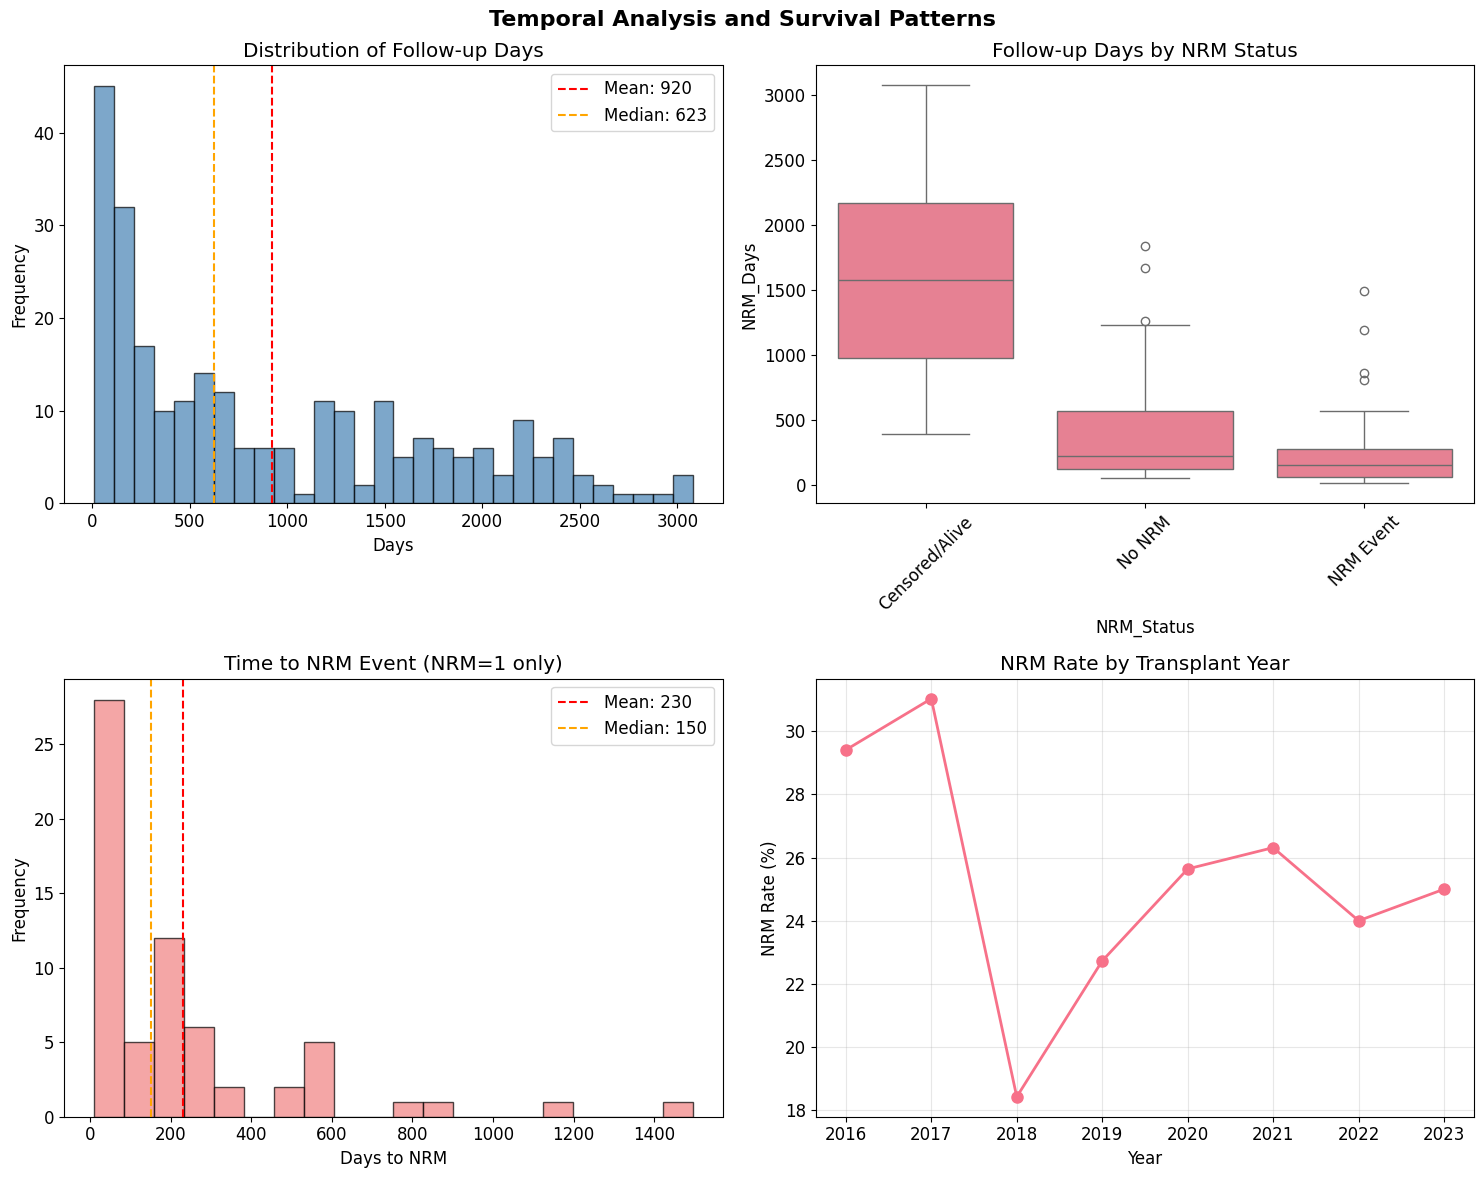

In [5]:
# Time-to-event analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Temporal Analysis and Survival Patterns', fontsize=16, fontweight='bold')

# 1. NRM_Days distribution
axes[0,0].hist(df['NRM_Days'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0,0].axvline(df['NRM_Days'].mean(), color='red', linestyle='--', label=f'Mean: {df["NRM_Days"].mean():.0f}')
axes[0,0].axvline(df['NRM_Days'].median(), color='orange', linestyle='--', label=f'Median: {df["NRM_Days"].median():.0f}')
axes[0,0].set_title('Distribution of Follow-up Days')
axes[0,0].set_xlabel('Days')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# 2. NRM_Days by status
sns.boxplot(data=df, x='NRM_Status', y='NRM_Days', ax=axes[0,1])
axes[0,1].set_title('Follow-up Days by NRM Status')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Time to NRM event (only for NRM=1)
nrm_events = df[df['NRM'] == 1]
if len(nrm_events) > 0:
    axes[1,0].hist(nrm_events['NRM_Days'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1,0].axvline(nrm_events['NRM_Days'].mean(), color='red', linestyle='--', 
                     label=f'Mean: {nrm_events["NRM_Days"].mean():.0f}')
    axes[1,0].axvline(nrm_events['NRM_Days'].median(), color='orange', linestyle='--', 
                     label=f'Median: {nrm_events["NRM_Days"].median():.0f}')
    axes[1,0].set_title('Time to NRM Event (NRM=1 only)')
    axes[1,0].set_xlabel('Days to NRM')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].legend()

# 4. NRM rate by year
yearly_nrm = df.groupby('Transplant_Year')['NRM'].apply(lambda x: (x == 1).sum() / len(x) * 100)
axes[1,1].plot(yearly_nrm.index, yearly_nrm.values, marker='o', linewidth=2, markersize=8)
axes[1,1].set_title('NRM Rate by Transplant Year')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('NRM Rate (%)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Risk Factor Analysis

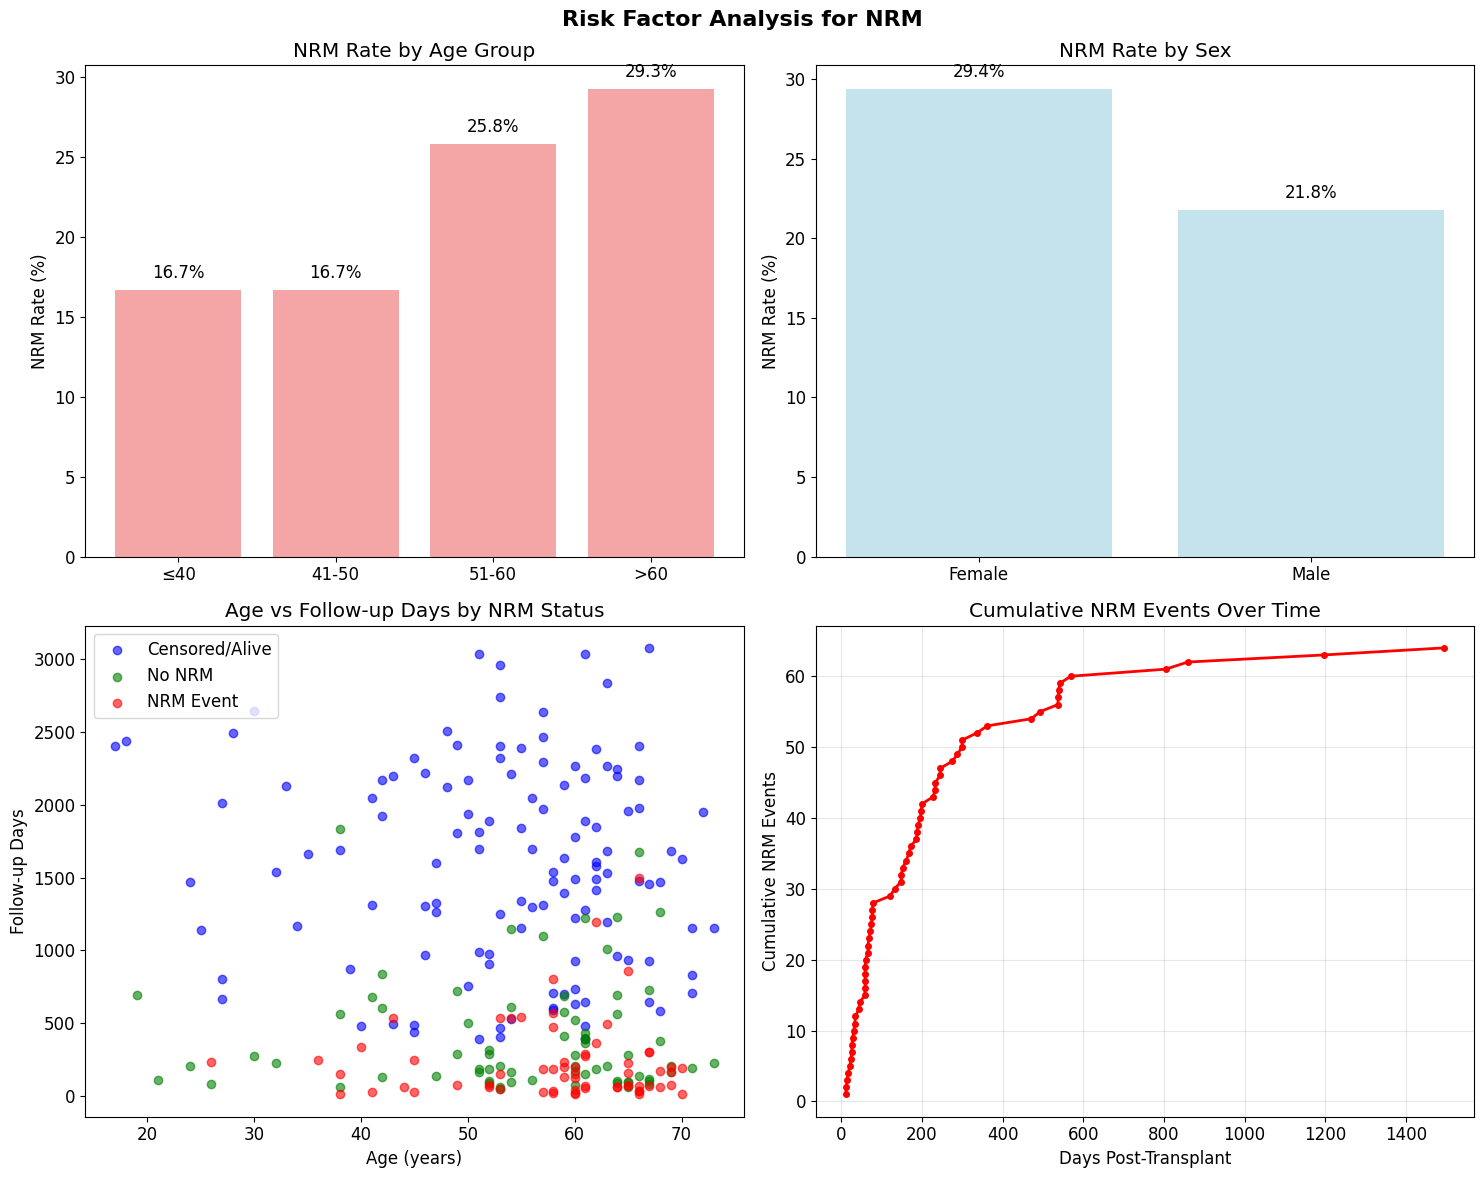

In [6]:
# Risk factor analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Risk Factor Analysis for NRM', fontsize=16, fontweight='bold')

# 1. NRM rate by age group
age_nrm_rate = df.groupby('Age_Group')['NRM'].apply(lambda x: (x == 1).sum() / len(x) * 100)
bars1 = axes[0,0].bar(age_nrm_rate.index, age_nrm_rate.values, alpha=0.7, color='lightcoral')
axes[0,0].set_title('NRM Rate by Age Group')
axes[0,0].set_ylabel('NRM Rate (%)')
# Add value labels on bars
for bar, value in zip(bars1, age_nrm_rate.values):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                  f'{value:.1f}%', ha='center', va='bottom')

# 2. NRM rate by sex
sex_nrm_rate = df.groupby('Sex_Label')['NRM'].apply(lambda x: (x == 1).sum() / len(x) * 100)
bars2 = axes[0,1].bar(sex_nrm_rate.index, sex_nrm_rate.values, alpha=0.7, color='lightblue')
axes[0,1].set_title('NRM Rate by Sex')
axes[0,1].set_ylabel('NRM Rate (%)')
# Add value labels on bars
for bar, value in zip(bars2, sex_nrm_rate.values):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                  f'{value:.1f}%', ha='center', va='bottom')

# 3. Age vs NRM_Days scatter
colors_map = {'No NRM': 'green', 'NRM Event': 'red', 'Censored/Alive': 'blue'}
for status in df['NRM_Status'].unique():
    subset = df[df['NRM_Status'] == status]
    axes[1,0].scatter(subset['Age'], subset['NRM_Days'], 
                     alpha=0.6, label=status, color=colors_map[status])
axes[1,0].set_title('Age vs Follow-up Days by NRM Status')
axes[1,0].set_xlabel('Age (years)')
axes[1,0].set_ylabel('Follow-up Days')
axes[1,0].legend()

# 4. Cumulative NRM events over time
nrm_events_sorted = nrm_events.sort_values('NRM_Days') if len(nrm_events) > 0 else pd.DataFrame()
if len(nrm_events_sorted) > 0:
    cumulative_events = range(1, len(nrm_events_sorted) + 1)
    axes[1,1].plot(nrm_events_sorted['NRM_Days'], cumulative_events, 
                  marker='o', markersize=4, linewidth=2, color='red')
    axes[1,1].set_title('Cumulative NRM Events Over Time')
    axes[1,1].set_xlabel('Days Post-Transplant')
    axes[1,1].set_ylabel('Cumulative NRM Events')
    axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Interactive Visualizations with Plotly

In [8]:
# Interactive 3D scatter plot
fig_3d = px.scatter_3d(df, x='Age', y='NRM_Days', z='Transplant_Year',
                      color='NRM_Status', size='Age',
                      title='3D View: Age, Follow-up Days, and Transplant Year by NRM Status',
                      labels={'NRM_Days': 'Follow-up Days', 'Transplant_Year': 'Transplant Year'})
fig_3d.show()

# Interactive timeline
fig_timeline = px.timeline(df.head(50), x_start='Transplant Day Zero', 
                          x_end=pd.to_datetime(df['Transplant Day Zero'].head(50)) + pd.to_timedelta(df['NRM_Days'].head(50), unit='D'),
                          y='Initials', color='NRM_Status',
                          title='Patient Timeline (First 50 patients)',
                          labels={'x': 'Timeline'})
fig_timeline.update_yaxes(autorange="reversed")
fig_timeline.show()

## 6. Statistical Summary and Key Insights

In [9]:
# Comprehensive statistical summary
print("=" * 60)
print("COMPREHENSIVE NRM DATASET ANALYSIS SUMMARY")
print("=" * 60)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   • Total patients: {len(df):,}")
print(f"   • Study period: {df['Transplant_Year'].min()}-{df['Transplant_Year'].max()}")
print(f"   • Age range: {df['Age'].min()}-{df['Age'].max()} years (mean: {df['Age'].mean():.1f}±{df['Age'].std():.1f})")
print(f"   • Sex distribution: {(df['Sex']==1).sum()} male ({(df['Sex']==1).sum()/len(df)*100:.1f}%), {(df['Sex']==2).sum()} female ({(df['Sex']==2).sum()/len(df)*100:.1f}%)")

print(f"\n🏥 NON-RELAPSE MORTALITY OUTCOMES:")
nrm_event_count = (df['NRM'] == 1).sum()
no_nrm_count = (df['NRM'] == 0).sum()
censored_count = (df['NRM'] == 2).sum()
print(f"   • NRM events: {nrm_event_count} ({nrm_event_count/len(df)*100:.1f}%)")
print(f"   • No NRM: {no_nrm_count} ({no_nrm_count/len(df)*100:.1f}%)")
print(f"   • Censored/Alive: {censored_count} ({censored_count/len(df)*100:.1f}%)")

if nrm_event_count > 0:
    nrm_subset = df[df['NRM'] == 1]
    print(f"\n⏱️  TIME TO NRM EVENTS:")
    print(f"   • Median time to NRM: {nrm_subset['NRM_Days'].median():.0f} days")
    print(f"   • Range: {nrm_subset['NRM_Days'].min()}-{nrm_subset['NRM_Days'].max()} days")
    print(f"   • Early events (<100 days): {(nrm_subset['NRM_Days'] < 100).sum()} ({(nrm_subset['NRM_Days'] < 100).sum()/len(nrm_subset)*100:.1f}%)")

print(f"\n📈 RISK FACTORS:")
age_groups = df.groupby('Age_Group')['NRM'].apply(lambda x: (x == 1).sum() / len(x) * 100)
sex_groups = df.groupby('Sex_Label')['NRM'].apply(lambda x: (x == 1).sum() / len(x) * 100)
print(f"   • NRM rate by age group:")
for age_grp, rate in age_groups.items():
    print(f"     - {age_grp}: {rate:.1f}%")
print(f"   • NRM rate by sex:")
for sex, rate in sex_groups.items():
    print(f"     - {sex}: {rate:.1f}%")

print(f"\n📊 TEMPORAL TRENDS:")
yearly_trends = df.groupby('Transplant_Year')['NRM'].apply(lambda x: (x == 1).sum() / len(x) * 100)
print(f"   • Yearly NRM rates:")
for year, rate in yearly_trends.items():
    patient_count = len(df[df['Transplant_Year'] == year])
    print(f"     - {year}: {rate:.1f}% (n={patient_count})")

print(f"\n🔍 KEY CLINICAL INSIGHTS:")
print(f"   • {nrm_event_count/len(df)*100:.1f}% of patients experienced non-relapse mortality")
if nrm_event_count > 0:
    early_nrm = (nrm_subset['NRM_Days'] < 100).sum()
    print(f"   • {early_nrm/nrm_event_count*100:.1f}% of NRM events occurred within first 100 days")
    print(f"   • Critical period appears to be first {nrm_subset['NRM_Days'].quantile(0.75):.0f} days post-transplant")

highest_risk_age = age_groups.idxmax()
print(f"   • Highest risk age group: {highest_risk_age} ({age_groups[highest_risk_age]:.1f}% NRM rate)")

print(f"\n" + "=" * 60)

COMPREHENSIVE NRM DATASET ANALYSIS SUMMARY

📊 DATASET OVERVIEW:
   • Total patients: 258
   • Study period: 2016-2023
   • Age range: 17-73 years (mean: 55.1±11.7)
   • Sex distribution: 156 male (60.5%), 102 female (39.5%)

🏥 NON-RELAPSE MORTALITY OUTCOMES:
   • NRM events: 64 (24.8%)
   • No NRM: 71 (27.5%)
   • Censored/Alive: 123 (47.7%)

⏱️  TIME TO NRM EVENTS:
   • Median time to NRM: 150 days
   • Range: 11-1495 days
   • Early events (<100 days): 28 (43.8%)

📈 RISK FACTORS:
   • NRM rate by age group:
     - ≤40: 16.7%
     - 41-50: 16.7%
     - 51-60: 25.8%
     - >60: 29.3%
   • NRM rate by sex:
     - Female: 29.4%
     - Male: 21.8%

📊 TEMPORAL TRENDS:
   • Yearly NRM rates:
     - 2016: 29.4% (n=17)
     - 2017: 31.0% (n=29)
     - 2018: 18.4% (n=38)
     - 2019: 22.7% (n=44)
     - 2020: 25.6% (n=39)
     - 2021: 26.3% (n=38)
     - 2022: 24.0% (n=25)
     - 2023: 25.0% (n=28)

🔍 KEY CLINICAL INSIGHTS:
   • 24.8% of patients experienced non-relapse mortality
   • 43.8% of

## 7. Export Summary Data

In [ ]:
# Create summary tables for export
summary_stats = {
    'Metric': ['Total Patients', 'NRM Events', 'NRM Rate (%)', 'Median Age', 'Male Patients (%)', 
              'Median Time to NRM (days)', 'Early NRM <100 days (%)'],
    'Value': [len(df), nrm_event_count, f"{nrm_event_count/len(df)*100:.1f}", 
             f"{df['Age'].median():.0f}", f"{(df['Sex']==1).sum()/len(df)*100:.1f}",
             f"{nrm_subset['NRM_Days'].median():.0f}" if nrm_event_count > 0 else "N/A",
             f"{(nrm_subset['NRM_Days'] < 100).sum()/len(nrm_subset)*100:.1f}" if nrm_event_count > 0 else "N/A"]
}

summary_df = pd.DataFrame(summary_stats)
print("Summary Statistics Table:")
print(summary_df.to_string(index=False))

# Save enhanced dataset with derived features
df_enhanced = df.copy()
df_enhanced.to_csv('nrm_analysis_enhanced.csv', index=False)
print(f"\n✅ Enhanced dataset saved as 'nrm_analysis_enhanced.csv'")
print(f"   Added features: Sex_Label, NRM_Status, Age_Group, Transplant_Year, Transplant_Month")